## Predicting the cost of health insurance for a person
The important insurance company 4Geeks Insurance S.L. wants to calculate, based on the physiological data of its customers what will be the premium (cost) to be borne by each of them. To do this, it has assembled a whole team of doctors, and based on data from other companies and a particular study, it has managed to gather a set of data to train a predictive model.

In [54]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score)
from sklearn.model_selection import GridSearchCV
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
# 1 Create data frame
# 1.1 Read from source and get basic info
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
df_raw.sample(10, random_state=2024)

,age,sex,bmi,children,smoker,region,charges
380,27,female,17.955,2,yes,northeast,15006.57945
684,33,female,18.500,1,no,southwest,4766.02200
356,46,male,43.890,3,no,southeast,8944.11510
208,63,female,31.800,0,no,southwest,13880.94900
20,60,female,36.005,0,no,northeast,13228.84695
721,53,male,36.600,3,no,southwest,11264.54100
1048,25,female,22.515,1,no,northwest,3594.17085
142,34,male,25.300,2,yes,southeast,18972.49500
1208,37,female,25.555,1,yes,northeast,20296.86345
520,50,female,27.360,0,no,northeast,25656.57526


In [10]:
# Step 2. Prepare the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .rename(columns={'charges':'target'})
    .astype({'sex':'category',
             'smoker':'category',
             'region':'category'})
)

In [11]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   target    1338 non-null   float64 
 1   age       1338 non-null   int64   
 2   sex       1338 non-null   category
 3   bmi       1338 non-null   float64 
 4   children  1338 non-null   int64   
 5   smoker    1338 non-null   category
 6   region    1338 non-null   category
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


In [12]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 270 to 928
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   target    1070 non-null   float64 
 1   age       1070 non-null   int64   
 2   sex       1070 non-null   category
 3   bmi       1070 non-null   float64 
 4   children  1070 non-null   int64   
 5   smoker    1070 non-null   category
 6   region    1070 non-null   category
dtypes: category(3), float64(2), int64(2)
memory usage: 45.4 KB


In [13]:
# 3.2 Descriptive Statistics
display(df_train.describe(include="number").T)
display(df_train.describe(include="category").T)

,count,mean,std,min,25%,50%,75%,max
target,1070.0,13344.424996,12079.019880,1121.8739,4726.388412,9423.92265,16584.318157,60021.39897
age,1070.0,39.275701,14.069707,18.0000,27.000000,39.00000,51.000000,64.00000
bmi,1070.0,30.603794,6.086464,15.9600,26.237500,30.30000,34.485000,53.13000
children,1070.0,1.105607,1.208431,0.0000,0.000000,1.00000,2.000000,5.00000


,count,unique,top,freq
sex,1070,2,male,541
smoker,1070,2,no,850
region,1070,4,southeast,280


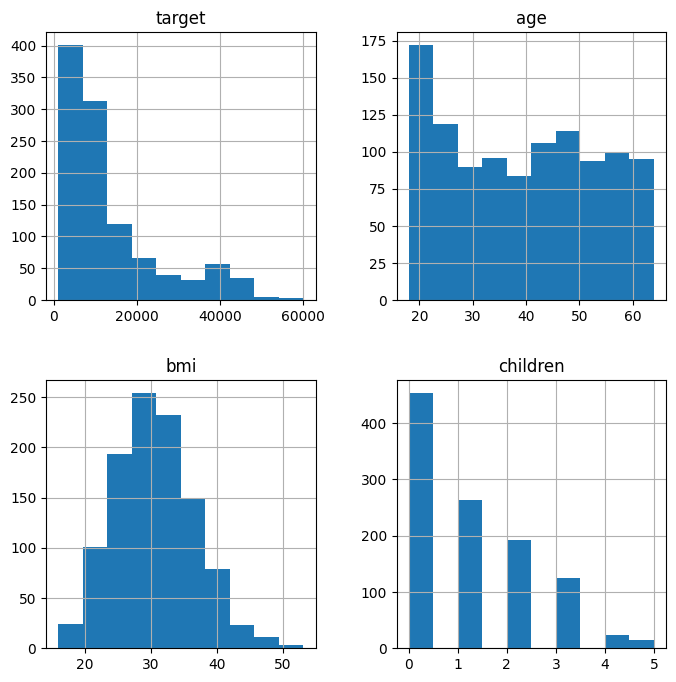

In [14]:
# 3.3 Create univariate analysis- numerical features
df_train.hist(figsize=(8,8))
plt.show()

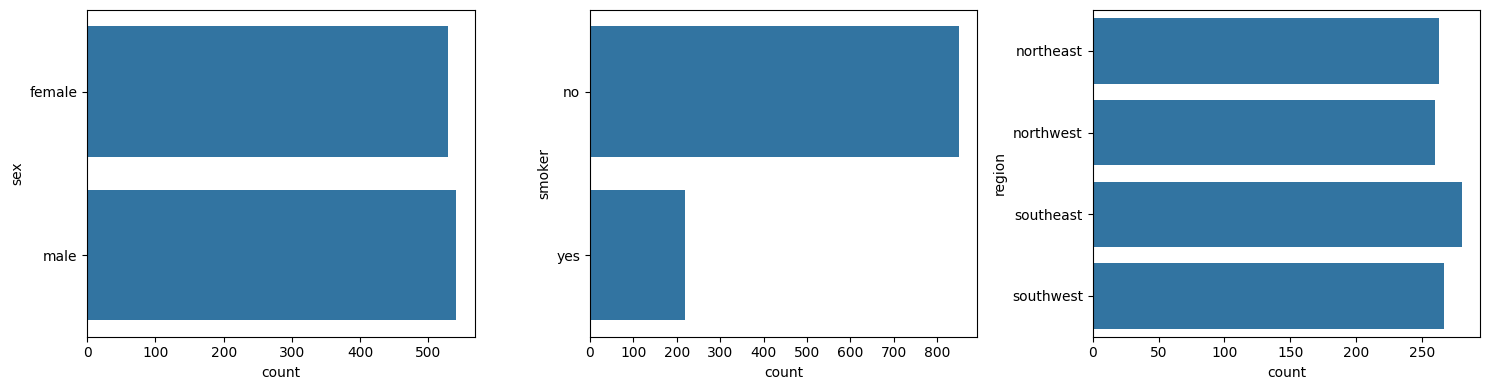

In [23]:
# 3.6 Create univariate analysis- categorical features
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.countplot(data=df_train, y='sex', ax=ax[0])
sns.countplot(data=df_train, y='smoker', ax=ax[1])
sns.countplot(data=df_train, y='region', ax=ax[2])
fig.tight_layout()
plt.show()

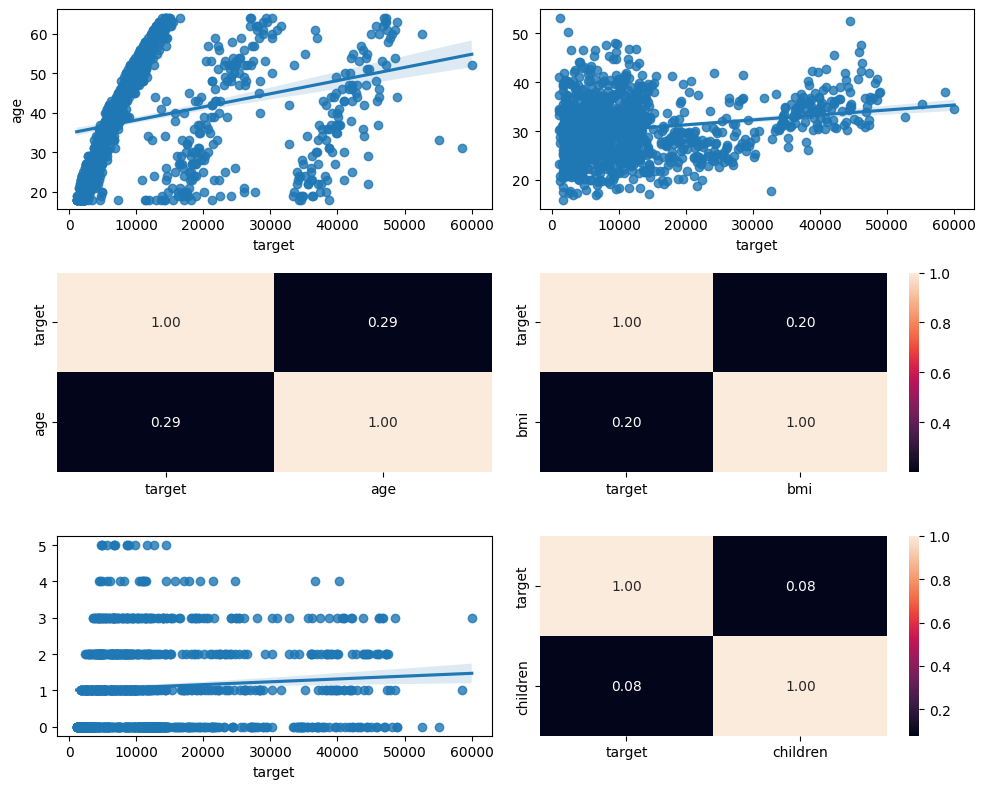

In [25]:
# Análisis bivariado variables numéricas
fig, axis = plt.subplots(3, 2, figsize=(10, 8))

# Gráficos de regresión y heatmaps
sns.regplot(ax=axis[0, 0], data=df_train, x="target", y="age")
sns.heatmap(df_train[["target", "age"]].corr(), annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)
sns.regplot(ax=axis[0, 1], data=df_train, x="target", y="bmi").set(ylabel=None)
sns.heatmap(df_train[["target", "bmi"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])
sns.regplot(ax=axis[2, 0], data=df_train, x="target", y="children").set(ylabel=None)
sns.heatmap(df_train[["target", "children"]].corr(), annot=True, fmt=".2f", ax=axis[2, 1])

# Ajustar diseño
plt.tight_layout()
plt.show()

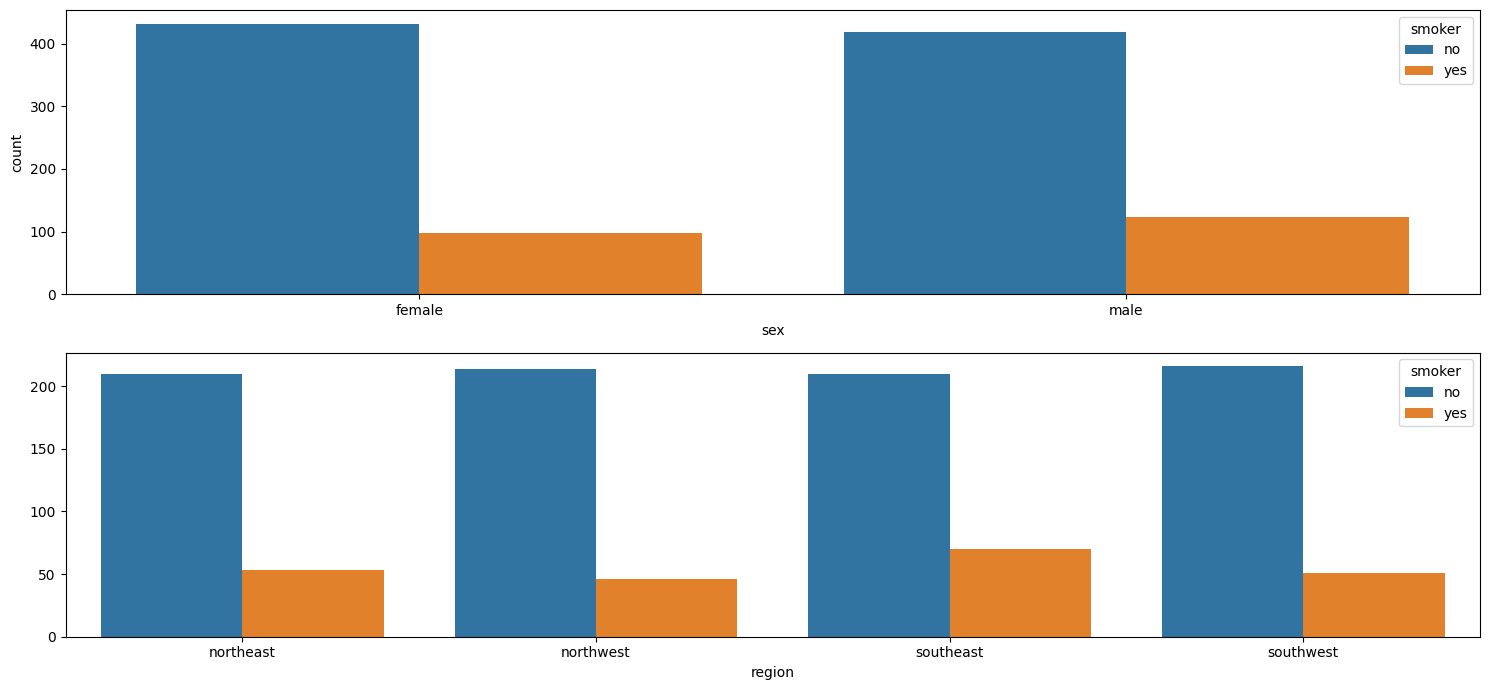

In [36]:
#Análisis bivariado variables categóricas
fig, axis = plt.subplots(2, 1, figsize=(15, 7))
sns.countplot(ax=axis[0], data=df_train, x="sex", hue="smoker")
sns.countplot(ax=axis[1], data=df_train, x="region", hue="smoker").set(ylabel=None)
plt.tight_layout()
plt.show()

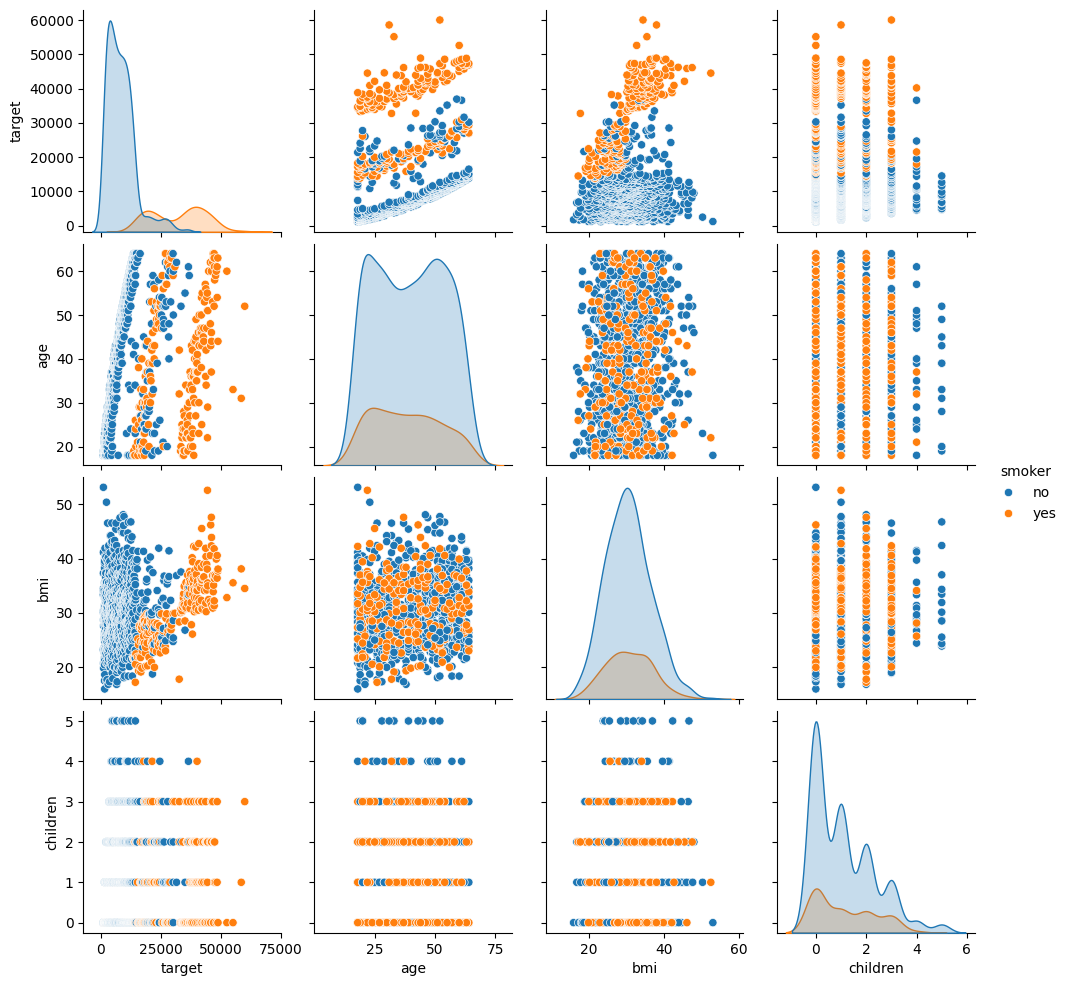

In [35]:
# Análisis bivariado variables numéricas vs categóricas
sns.pairplot(data = df_train, hue = "smoker")
plt.show()

In [29]:
# Step 4. Create a machine learning model
# 4.1 Split features and reponse
X_train = df_train.reset_index(drop=True).drop('target', axis=1)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.reset_index(drop=True).drop('target', axis=1)
y_test = df_test['target'].reset_index(drop=True)

In [37]:
# 4.2 Create a pipeline
cat_cols = X_train.select_dtypes(include='category').columns
num_cols = X_train.select_dtypes(include='number').columns

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary'))
])

num_transformer = Pipeline(steps = [
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers = [
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

In [61]:
# 4.3 Create the model with Random Forest
linear_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_test)

In [62]:
# 4.4 Get the metrics
mae = np.round(mean_absolute_error(y_test, y_pred), 1)
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = np.round(r2_score(y_test, y_pred), 2)
print(f'MAE: {mae}, RMSE: {rmse}, R2: {r2}')

MAE: 4453.0, RMSE: 6579.0, R2: 0.71


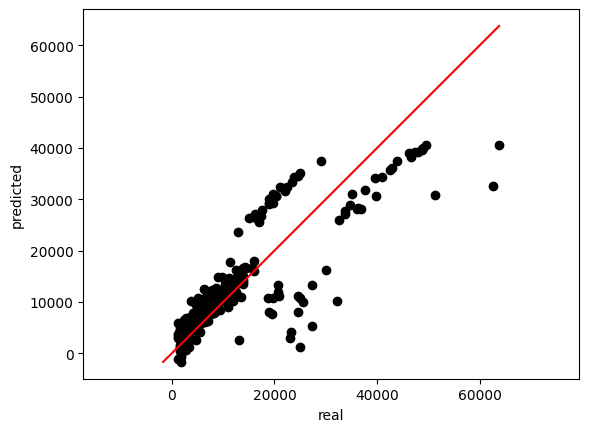

In [53]:
# 4.5 Graph prediction
plt.scatter(x= y_test, y= y_pred, c= 'k')
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], c='r')
#plt.plot([500,-50],[60000,40000], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()